## janesick_nature_comms_2023, scRNA

In [1]:
import time
from pathlib import Path
proj_name = "janesick_nc_2023_dev"
save_dir = f"../save/dev_{proj_name}-{time.strftime('%b%d')}/"
save_dir = Path(save_dir)
save_dir.mkdir(parents=True, exist_ok=True)

data_dir = f"../data/janesick_nature_comms_2023/"
data_dir = Path(data_dir)

file_suffix = f"{time.strftime('%b%d-%H%M')}"
file_suffix

'Jun05-2207'

### 3prime

In [2]:
import scanpy as sc
import pandas as pd

from pathlib import Path
p5_path = Path("../data/janesick_nature_comms_2023/scRNA_p5/").expanduser()

# Load data
p5_adata = sc.read_10x_h5(p5_path / "SC5v2_GEX_Breast_Cancer_DTC_Aggr_count_filtered_feature_bc_matrix.h5")


/opt/anaconda3/envs/concord/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/concord/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [3]:
# Normalize visium_adata
p5_adata.layers['counts'] = p5_adata.X.copy()
sc.pp.normalize_total(p5_adata, target_sum=1e4)
# log transform
sc.pp.log1p(p5_adata)
# PCA and UMAP
n_latent = 30
sc.pp.pca(p5_adata, n_comps=n_latent, svd_solver='arpack')
sc.pp.neighbors(p5_adata, n_neighbors=15, n_pcs=n_latent)
sc.tl.umap(p5_adata, min_dist=0.1, n_components=2)
sc.tl.leiden(p5_adata, resolution=0.5, key_added='leiden', random_state=42)

/opt/anaconda3/envs/concord/lib/python3.12/site-packages/sklearn/utils/sparsefuncs.py:736: RuntimeWarning: divide by zero encountered in matmul
  matvec=lambda x: X @ x - offset @ x,
/opt/anaconda3/envs/concord/lib/python3.12/site-packages/sklearn/utils/sparsefuncs.py:736: RuntimeWarning: overflow encountered in matmul
  matvec=lambda x: X @ x - offset @ x,
/opt/anaconda3/envs/concord/lib/python3.12/site-packages/sklearn/utils/sparsefuncs.py:736: RuntimeWarning: invalid value encountered in matmul
  matvec=lambda x: X @ x - offset @ x,
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/var/folders/wl/5x49grmn56v77c01bw965mj00000gn/T/ipykernel_54327/1014595099.py:11: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(p5_adata, resolu

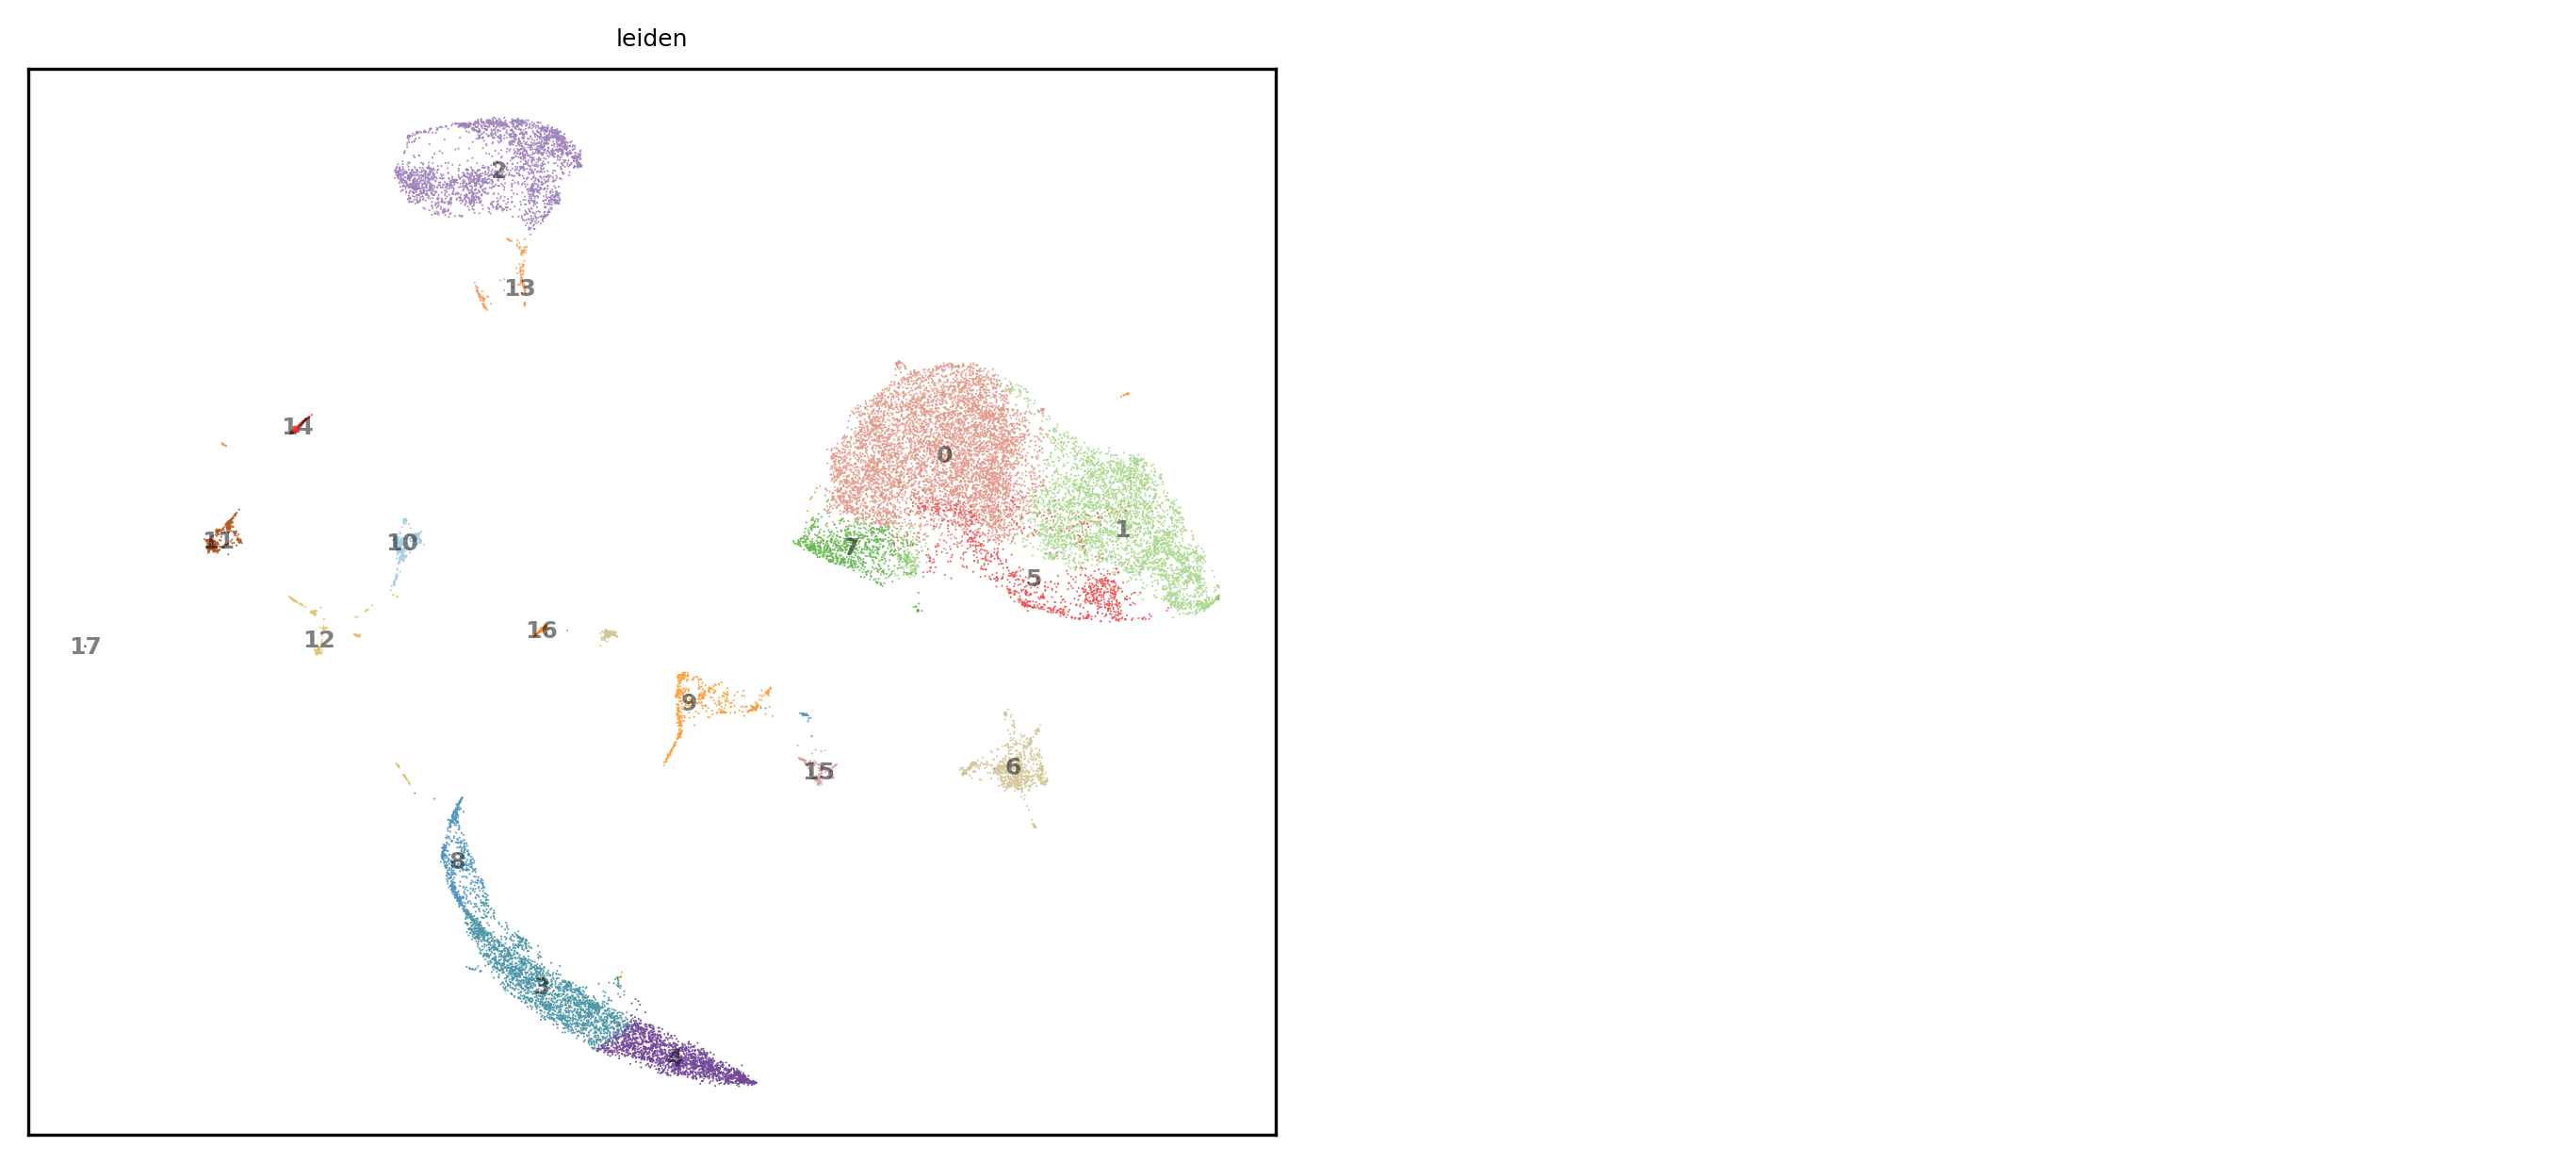

In [4]:
import concord as ccd
_, _, clus_pal = ccd.pl.get_color_mapping(p5_adata, 'leiden', pal='Paired', seed=1)
pal = {'leiden':clus_pal}
show_basis = f'X_umap'
show_cols = ['leiden']
ccd.pl.plot_embedding(
    p5_adata, show_basis, show_cols, figsize=(9,4), dpi=300, ncols=2,  font_size=6, point_size=1, legend_loc='on data',
    pal=pal,
    save_path=save_dir / f"p5_embeddings_{show_basis}_{file_suffix}.png"
)

In [5]:
import concord as ccd
cur_ccd = ccd.Concord(adata=p5_adata, 
                      latent_dim = n_latent,
                      save_dir=save_dir, # directory to save model checkpoints
                      inplace=False, # whether to modify adata in place
                      ) 

# Encode data, saving the latent embedding in adata.obsm['Concord']
output_key = 'Concord'
cur_ccd.encode_adata(input_layer_key='X', output_key=output_key, preprocess=False)
p5_adata.obsm = cur_ccd.adata.obsm.copy()
# Save the latent embedding to a file, so that it can be loaded later
ccd.ul.save_obsm_to_hdf5(cur_ccd.adata, save_dir / f"p5_obsm_{file_suffix}.h5")

Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Concord - WARNING - domain/batch information not found, all samples will be treated as from single domain/batch.


FAISS not found. Using sklearn for k-NN computation.
You specified p_intra_domain as 0.95 but you only have one domain. Resetting p_intra_domain to 1.0.


p_intra_knn: 0.3


Epoch 0 Training: 358it [00:14, 23.99it/s, loss=3.54]
Epoch 9 Training: 100%|██████████| 358/358 [00:14<00:00, 24.64it/s, loss=3.37]


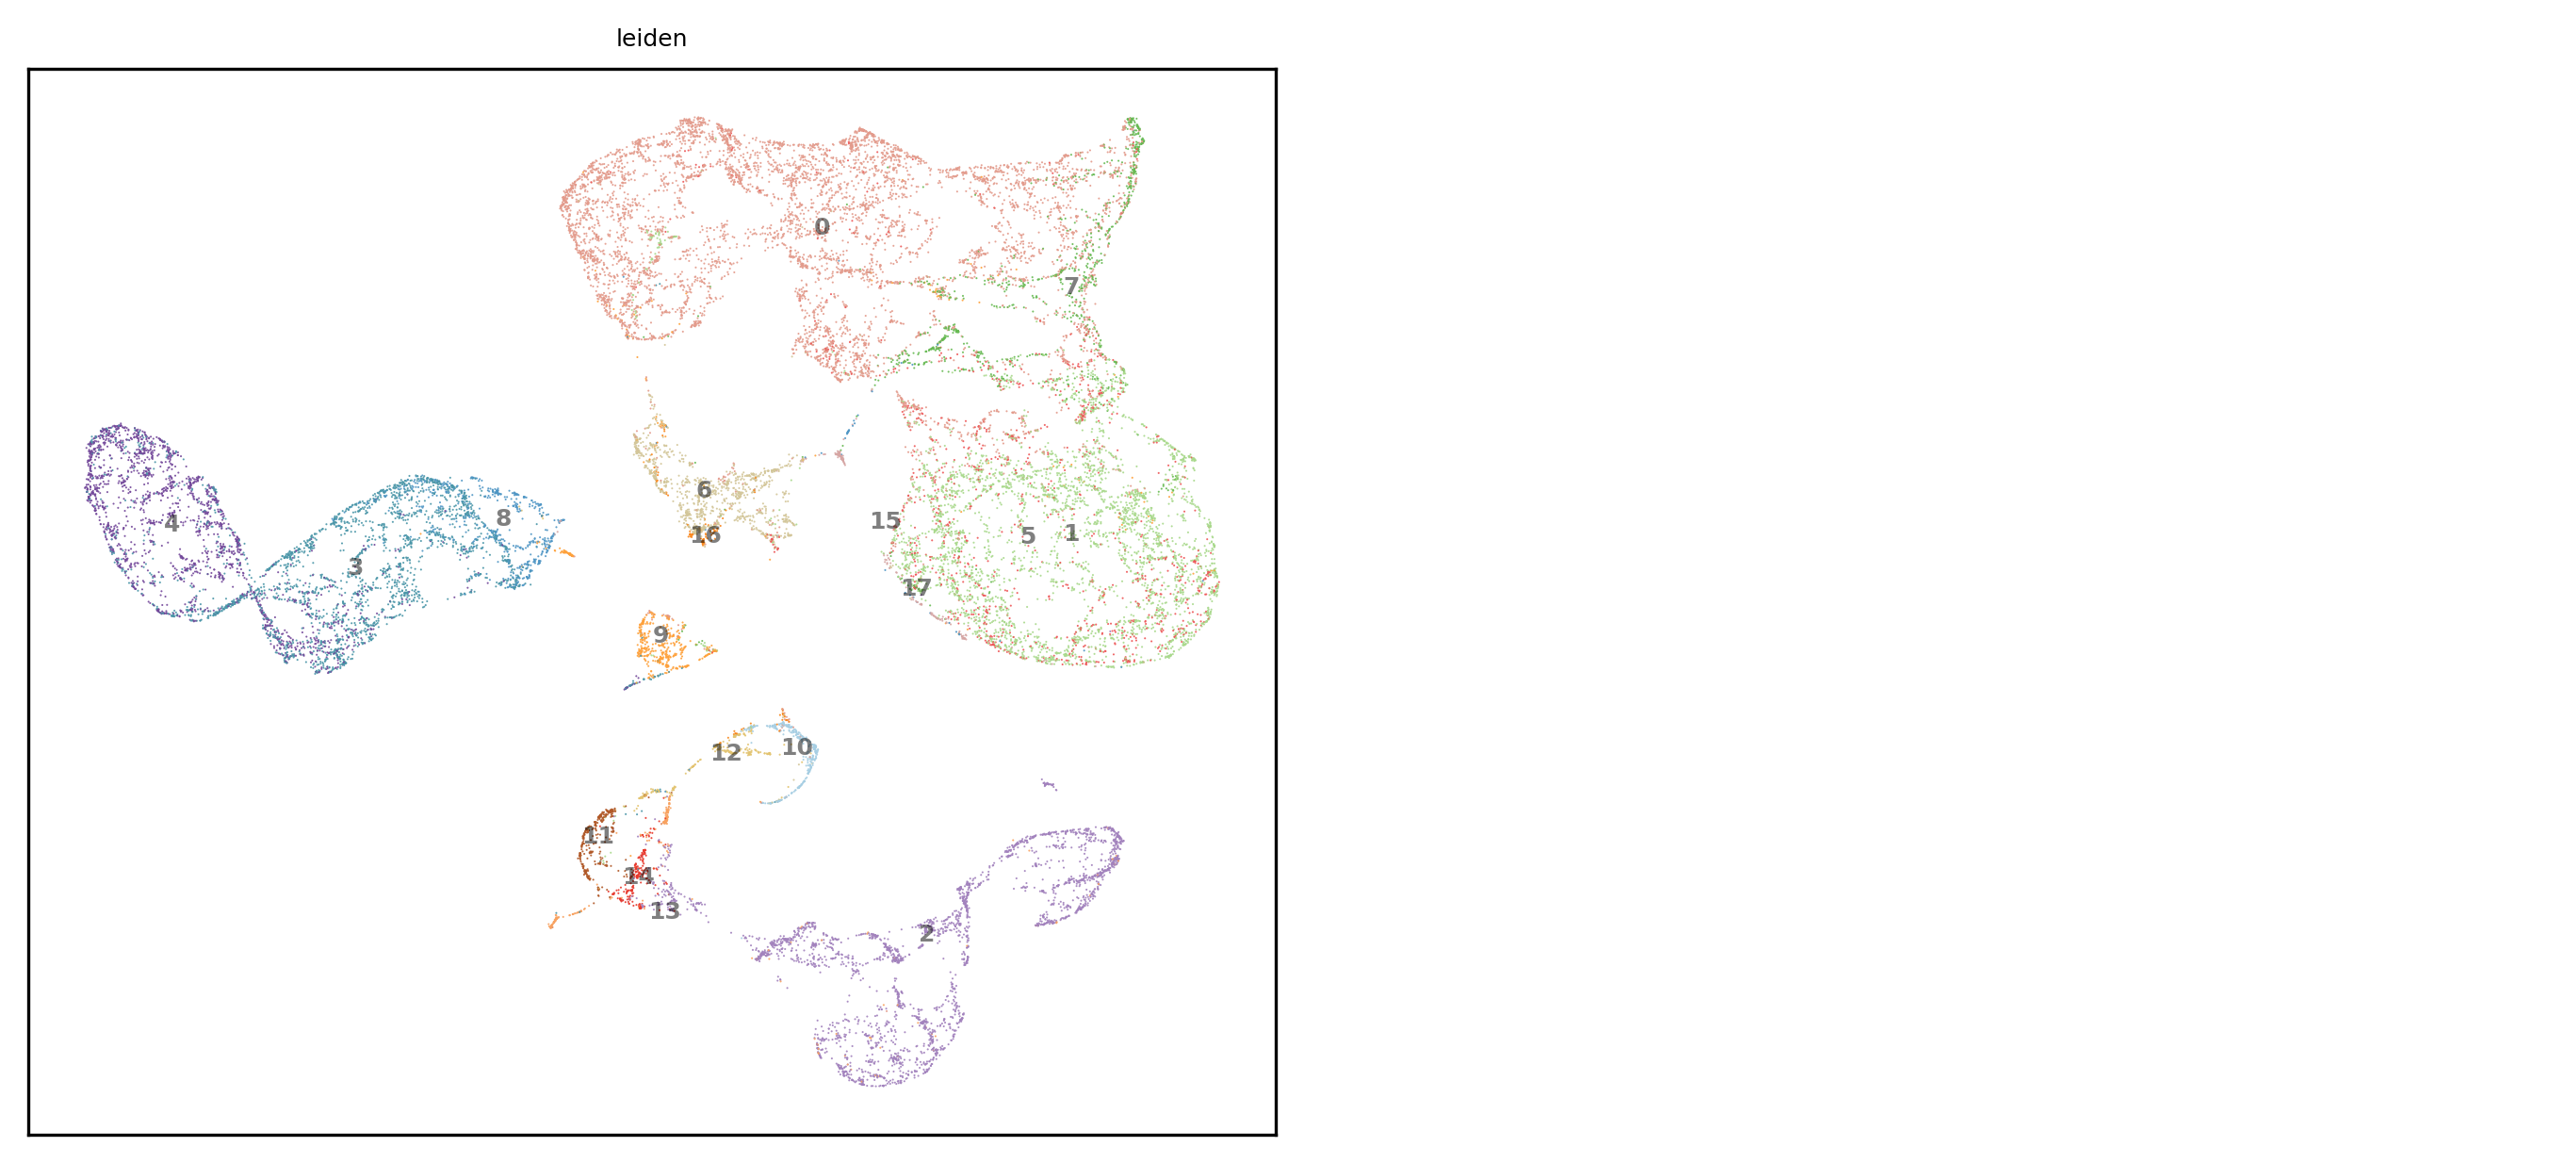

In [6]:
# compute umap
ccd.ul.run_umap(p5_adata, source_key=output_key, result_key=f'{output_key}_UMAP', n_components=2, n_neighbors=15, min_dist=0.1, metric='euclidean')
show_basis = f'{output_key}_UMAP'
show_cols = ['leiden']
ccd.pl.plot_embedding(
    p5_adata, show_basis, show_cols, figsize=(9,4), dpi=300, ncols=2, font_size=6, point_size=1, legend_loc='on data',
    pal=pal,
    save_path=save_dir / f"p5_embeddings_{show_basis}_{file_suffix}.png"
)

In [7]:
p5_adata.shape

(22969, 36601)

In [8]:
p5_adata.obs_names = "p5_" + p5_adata.obs_names.astype(str)
p5_adata.write_h5ad(data_dir / f"p5_adata_{file_suffix}.h5ad")
print(f"Saved p5_adata to {data_dir / f'p5_adata_{file_suffix}.h5ad'}")
ccd.ul.anndata_to_viscello(p5_adata, data_dir / f"cello_p5_{proj_name}_{file_suffix}", project_name = proj_name, organism='hsa')
print(f"Saved viscello to {data_dir / f'cello_p5_{proj_name}_{file_suffix}.h5ad'}")


Saved p5_adata to ../data/janesick_nature_comms_2023/p5_adata_Jun05-2207.h5ad
VisCello project created at ../data/janesick_nature_comms_2023/cello_p5_janesick_nc_2023_dev_Jun05-2207
Saved viscello to ../data/janesick_nature_comms_2023/cello_p5_janesick_nc_2023_dev_Jun05-2207.h5ad
